In [1]:
import pandas as pd

data = pd.read_pickle('/root/blocksnet/tests/data/data_with_geo_info.pickle')

# Social Indicators Prediction

## Predicting using quantile regression

In [2]:
from blocksnet.machine_learning.regression import SocialRegressor

ir = SocialRegressor(model_path='/root/blocksnet/blocksnet/machine_learning/regression/social/common/models/model.pickle')

#ir = SocialRegressor(n_estimators=100, max_depth=4, min_samples_split=5)

/root/blocksnet/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/blocksnet/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Models loaded from: /root/blocksnet/blocksnet/machine_learning/regression/social/common/models/model.pickle
Loaded model with following parameters
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Getting data divided into a training and a test sample

In [3]:
X_train, X_test, y_train, y_test = ir.get_train_data(data, scale_data=False)

Train model

In [4]:
# ir.train(X_train, y_train, confidence_level=95.0)
# ir.save_model('/root/blocksnet/blocksnet/machine_learning/regression/social/common/models/model.pickle')

## Model Validation

In [5]:
y_pred = ir.evaluate(X_test)

Showing predictions

In [6]:
pred_df, pi_df = ir.evaluate_with_intervals(X_test, inverse_transform=False)
stats_df = ir.calculate_interval_stats(pred_df, pi_df, y_test)
pred_df

,nursing_home_count,hotel_count,theatre_count,cinema_count,secondary_vocational_education_institutions_count,university_count,stadium_count,emergency_medical_service_stations_count,kindergarten_count,hostel_count,...,post_count,swimming_pool_count,library_count,guest_house_count,fire_safety_facilities_count,restaurant_count,police_count,museum_count,bank_count,pitch_count
14296,0.014,-0.001,0.002,0.016,0.039,0.479,0.105,0.006,0.297,0.011,...,0.073,0.020,0.040,0.034,0.033,0.093,0.038,0.029,0.065,0.988
3310,0.013,0.804,0.082,0.203,1.084,0.138,1.111,0.230,5.923,0.071,...,0.303,0.109,0.363,0.212,0.723,1.205,0.836,0.587,0.490,17.555
16148,0.249,13.240,0.481,1.551,3.687,1.599,2.781,0.268,23.174,0.916,...,1.558,13.684,1.686,0.225,1.782,15.103,2.446,1.885,1.572,84.766
17455,-0.003,0.010,-0.004,0.006,0.020,0.002,0.086,-0.000,0.384,-0.002,...,0.145,0.031,0.019,0.172,0.001,0.122,0.095,0.026,0.004,0.626
16291,0.013,0.088,0.003,0.020,0.035,0.024,0.250,0.008,0.771,0.012,...,0.444,0.006,0.135,0.156,0.168,0.179,0.075,0.083,0.012,1.926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.012,0.166,0.022,0.014,0.007,0.041,0.002,0.063,0.720,0.029,...,0.915,0.076,1.465,0.012,0.355,0.884,0.123,0.087,0.093,1.888
15907,-0.003,0.073,0.002,0.005,0.018,0.002,0.053,-0.000,0.288,0.006,...,0.250,0.028,0.021,0.170,0.042,0.132,0.009,0.021,0.000,0.246
3222,0.075,2.277,1.749,0.474,5.802,3.036,4.222,0.518,46.448,-0.117,...,3.030,3.403,1.047,1.638,2.487,7.802,3.382,1.221,3.787,76.015
17201,-0.003,-0.014,0.002,0.003,0.016,0.004,0.003,-0.000,0.194,-0.003,...,0.041,-0.005,0.028,0.066,0.020,0.060,0.006,0.008,0.000,0.238


Showing prediction intervals

In [7]:
pi_df

,nursing_home_count,hotel_count,theatre_count,cinema_count,secondary_vocational_education_institutions_count,university_count,stadium_count,emergency_medical_service_stations_count,kindergarten_count,hostel_count,...,post_count,swimming_pool_count,library_count,guest_house_count,fire_safety_facilities_count,restaurant_count,police_count,museum_count,bank_count,pitch_count
14296,"(0.0, 0.8)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.159)","(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 1.996)","(0.0, 0.0)",...,"(0.0, 1.834)","(0.0, 0.0)","(0.0, 0.95)","(0.0, 0.107)","(0.0, 1.0)","(0.0, 1.001)","(0.0, 0.134)","(0.0, 0.356)","(0.0, 1.0)","(0.0, 2.655)"
3310,"(0.0, 0.8)","(0.0, 6.322)","(0.0, 0.934)","(0.0, 1.1)","(0.0, 3.684)","(0.0, 2.215)","(0.0, 4.4)","(0.0, 1.065)","(0.0, 14.264)","(0.0, 1.0)",...,"(0.0, 1.84)","(0.0, 1.0)","(0.0, 1.761)","(0.0, 1.722)","(0.0, 2.808)","(0.0, 8.335)","(0.0, 3.968)","(0.0, 4.091)","(0.0, 2.599)","(0.0, 38.652)"
16148,"(0.0, 1.2)","(0.0, 49.797)","(0.0, 2.153)","(0.0, 2.46)","(0.0, 6.56)","(0.0, 4.629)","(0.0, 6.024)","(0.0, 1.729)","(0.0, 36.571)","(0.0, 2.704)",...,"(0.0, 2.498)","(0.0, 81.805)","(0.0, 3.052)","(0.0, 11.956)","(0.0, 4.281)","(0.0, 22.667)","(0.0, 5.653)","(0.0, 4.227)","(0.0, 2.698)","(0.0, 103.613)"
17455,"(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 1.822)","(0.0, 0.0)","(0.0, 1.012)","(0.0, 0.0)",...,"(0.0, 1.524)","(0.0, 0.0)","(0.0, 0.878)","(0.0, 1.335)","(0.0, 1.0)","(0.0, 1.001)","(0.0, 0.437)","(0.0, 0.298)","(0.0, 1.0)","(0.0, 2.118)"
16291,"(0.0, 0.8)","(0.0, 1.669)","(0.0, 0.46)","(0.0, 0.0)","(0.0, 1.1)","(0.0, 0.0)","(0.0, 1.902)","(0.0, 0.0)","(0.0, 3.415)","(0.0, 0.0)",...,"(0.0, 1.78)","(0.0, 1.0)","(0.0, 1.114)","(0.0, 2.099)","(0.0, 1.669)","(0.0, 2.0)","(0.0, 1.648)","(0.0, 1.395)","(0.0, 1.0)","(0.0, 6.649)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,"(0.0, 0.9)","(0.0, 3.375)","(0.0, 0.418)","(0.0, 0.0)","(0.0, 1.046)","(0.0, 0.447)","(0.0, 1.104)","(0.0, 0.0)","(0.0, 3.0)","(0.0, 0.0)",...,"(0.0, 2.894)","(0.0, 1.0)","(0.0, 2.728)","(0.0, 2.821)","(0.0, 1.0)","(0.0, 2.566)","(0.0, 0.999)","(0.0, 1.669)","(0.0, 1.0)","(0.0, 8.961)"
15907,"(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 1.996)","(0.0, 0.0)",...,"(0.0, 1.0)","(0.0, 0.0)","(0.0, 0.914)","(0.0, 1.582)","(0.0, 1.0)","(0.0, 1.001)","(0.0, 0.434)","(0.0, 0.315)","(0.0, 1.0)","(0.0, 2.349)"
3222,"(0.0, 1.3)","(0.0, 9.785)","(0.0, 3.409)","(0.0, 1.949)","(0.0, 8.788)","(0.0, 12.891)","(0.0, 8.916)","(0.0, 1.546)","(0.0, 49.275)","(0.0, 3.106)",...,"(0.0, 5.467)","(0.0, 10.144)","(0.0, 5.409)","(0.0, 6.357)","(0.0, 9.285)","(0.0, 32.111)","(0.0, 6.171)","(0.0, 10.018)","(0.0, 11.404)","(0.0, 116.359)"
17201,"(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0)","(0.0, 1.012)","(0.0, 0.0)",...,"(0.0, 1.0)","(0.0, 0.0)","(0.0, 0.868)","(0.0, 0.575)","(0.0, 1.0)","(0.0, 1.001)","(0.0, 0.006)","(0.0, 0.377)","(0.0, 1.0)","(0.0, 2.93)"


Showing validation statistics

In [8]:
stats_df

y,coverage_percentage,mean_interval_width,mse,rmse,mae,r2
nursing_home_count,99.474,0.421,0.024,0.155,0.046,-0.273
hotel_count,97.368,3.772,26.112,5.110,1.009,0.277
theatre_count,96.842,0.548,0.359,0.599,0.170,0.365
cinema_count,98.070,0.438,0.102,0.320,0.109,0.146
secondary_vocational_education_institutions_count,96.491,1.577,1.027,1.013,0.379,0.678
university_count,96.491,1.206,4.898,2.213,0.494,0.370
stadium_count,97.193,2.361,1.097,1.047,0.504,0.576
emergency_medical_service_stations_count,97.895,0.232,0.102,0.320,0.097,0.362
kindergarten_count,96.316,8.175,26.301,5.128,1.679,0.828
hostel_count,97.895,0.457,2.268,1.506,0.253,-1.489


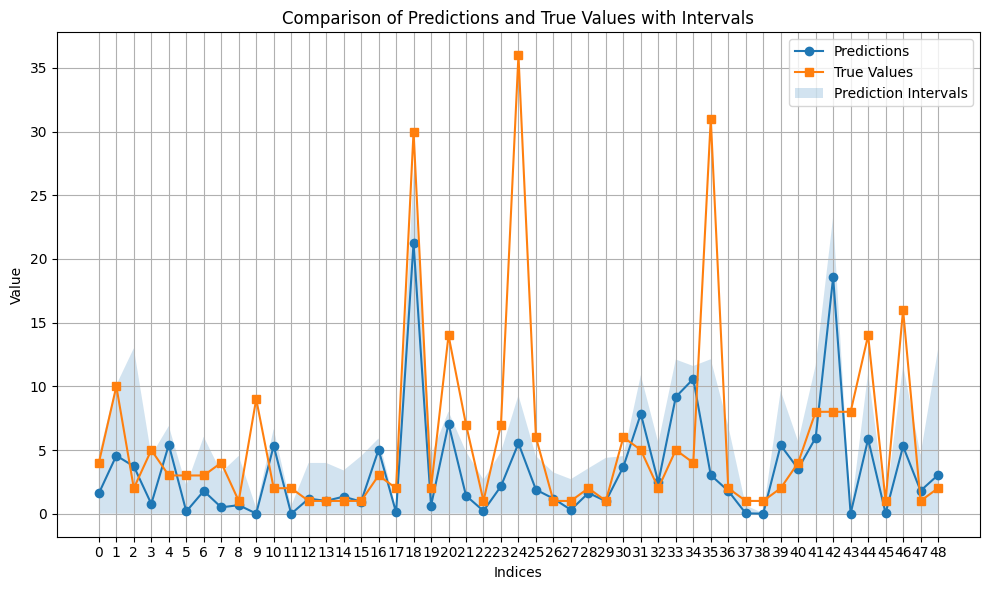

In [9]:
import numpy as np
import matplotlib.pyplot as plt

target_name = 'university_count'

# Filter data where y_test values are positive
mask = y_test[target_name].values > 0
filtered_pred_df = pred_df[mask]
filtered_pi_df = pi_df[mask]
filtered_y_true = y_test[mask]

# Parameters for slicing (default is full filtered range)
start_idx = 0  # Starting index (can be changed)
end_idx = 50   # Ending index (can be changed)

# Extract data from filtered DataFrames with slicing
x = np.linspace(0, len(filtered_pred_df) - 1, len(filtered_pred_df))[start_idx:end_idx + 1]
y_pred = filtered_pred_df[target_name].values[start_idx:end_idx + 1]
y_true = filtered_y_true[target_name].values[start_idx:end_idx + 1]

# Extract intervals from pi_df (now stored as tuples)
pi_data = filtered_pi_df[target_name].values[start_idx:end_idx + 1]
lower_bound = [interval[0] for interval in pi_data]  # Extract lower bound from tuple
upper_bound = [interval[1] for interval in pi_data]  # Extract upper bound from tuple

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y_pred, label='Predictions', marker='o')
plt.plot(x, y_true, label='True Values', marker='s')
plt.fill_between(x, lower_bound, upper_bound, alpha=0.2, label='Prediction Intervals')

# Configure the plot
plt.xlabel('Indices')
plt.ylabel('Value')
plt.title('Comparison of Predictions and True Values with Intervals')
plt.legend()
plt.grid(True)
plt.xticks(x)
plt.tight_layout()

## Error for different targets

[]

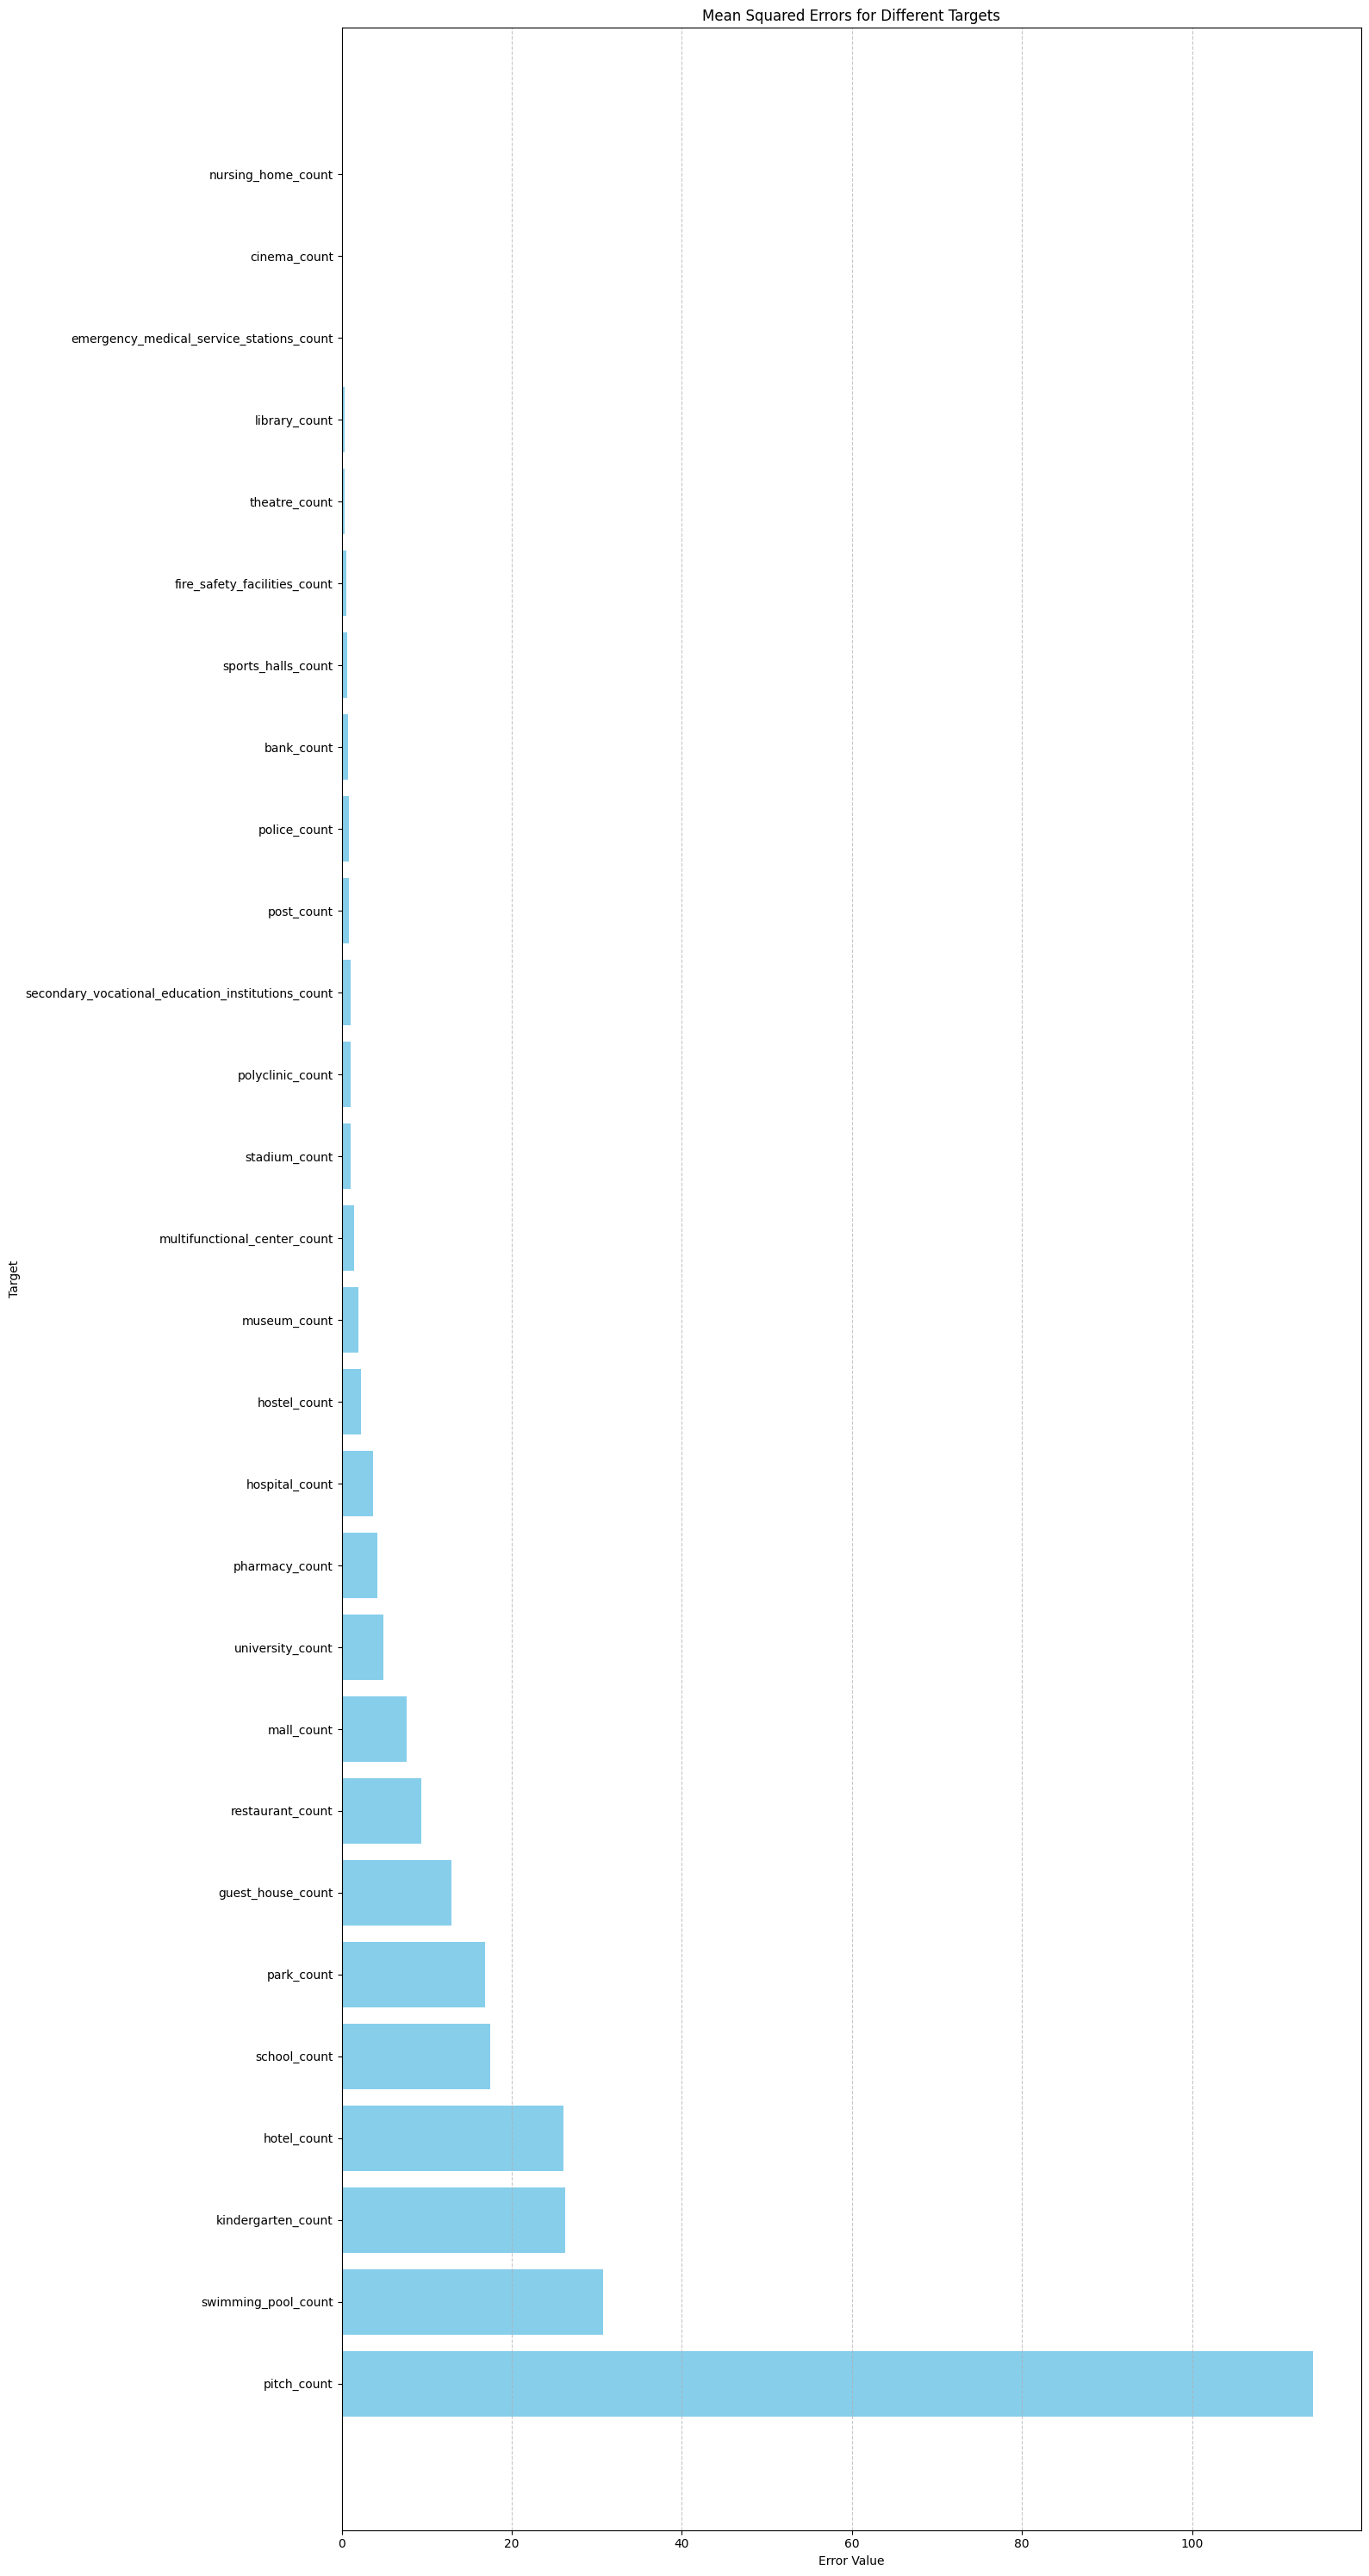

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stats_df is obtained from calculate_interval_stats and has been transposed
# Example: pred_df, pi_df = ir.predict_with_intervals(X_test, inverse_transform=False)
# stats_df = ir.calculate_interval_stats(pred_df, pi_df, y_test).T

# Extract MSE values and target names from transposed stats_df
mse = stats_df['mse'].values
target_names = stats_df.index

# Sort by descending MSE
sorted_indices = np.argsort(mse)[::-1]
sorted_mse = mse[sorted_indices]
sorted_targets = target_names[sorted_indices]

# Create horizontal bar plot
plt.figure(figsize=(16, 30))
plt.barh(sorted_targets, sorted_mse, color='skyblue')

# Add labels and title
plt.ylabel('Target')
plt.xlabel('Error Value')
plt.title('Mean Squared Errors for Different Targets')

# Add grid and save plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.plot()

## LIME Prediction

Mean Squared Error: 4.898
Predicted value: 0.479
Real value: 0.0
Explanation:
[('business > 15183.04', 2.9534802613554785), ('population <= 1136.00', -0.5860909439229887), ('transport <= 0.00', 0.3809469174382578), ('74914.77 < industrial <= 528208.61', -0.2871944980298722), ('buildings_count <= 4.00', -0.23936306374227934), ('area <= 63000.00', -0.1874804409055796), ('34922.80 < special <= 156359.65', -0.1421858470028649), ('footprint_area <= 0.00', -0.12259403792263908), ('longitude <= -883053.12', 0.12092895926078623), ('444312.69 < recreation <= 4056059.51', 0.10099483719723343)]


[]

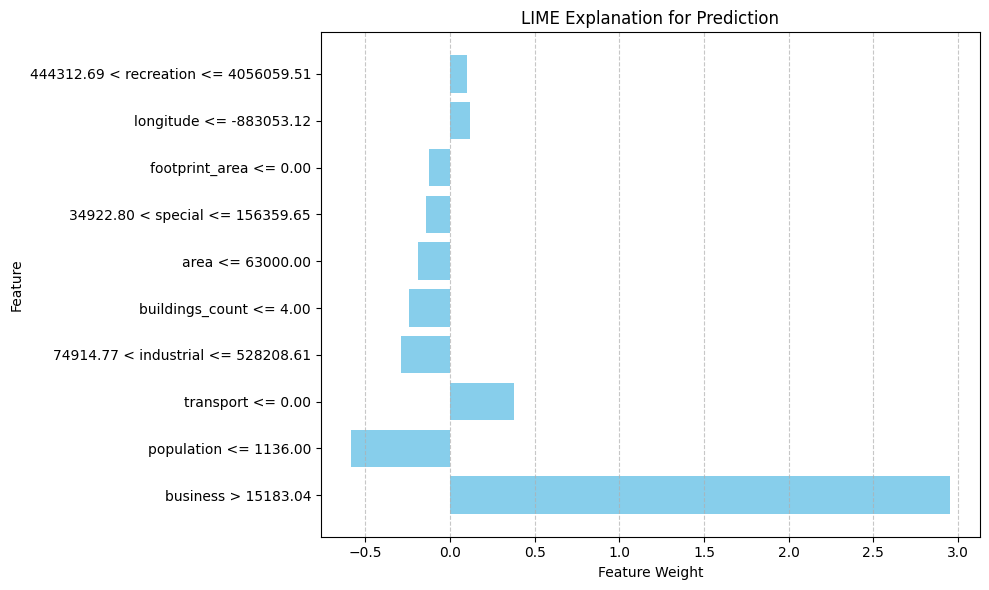

In [11]:
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Target column
column = 'university_count'

# Fill missing values in y_train
y_train = y_train.fillna(0)

# Use ir model for predictions
pred_df, pi_df = ir.evaluate_with_intervals(X_test, inverse_transform=False)

# Get MSE from stats_df (assuming stats_df is transposed)
stats_df = ir.calculate_interval_stats(pred_df, pi_df, y_test)
mse = stats_df.loc[column, 'mse']

# Print MSE
print(f'Mean Squared Error: {mse:.3f}')

# Helper function for LIME to predict with ir model for the specific column
def predict_fn(X):
    # Convert input to DataFrame with correct column names
    X_df = pd.DataFrame(X, columns=X_train.columns)
    # Get predictions from ir model
    pred_df, _ = ir.evaluate_with_intervals(X_df, inverse_transform=False)
    # Return predictions for the specific column
    return pred_df[column].values

# Create LIME explainer for tabular data
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Convert DataFrame to numpy array
    feature_names=X_train.columns,  # Feature names
    class_names=[column],  # Target name for regression
    mode='regression',  # Task type: regression
    random_state=42
)

# Select one instance for interpretation (e.g., first from test set)
i = 0
instance = X_test.iloc[i].values.reshape(1, -1)

# Get explanation for the selected instance
explanation = explainer.explain_instance(instance[0], predict_fn)

# Print prediction and real value
print("Predicted value:", pred_df[column].iloc[i])
print("Real value:", y_test[column].iloc[i])
print("Explanation:")
print(explanation.as_list())

# Get explanation as a list
explanation_list = explanation.as_list()

# Split explanation into features and weights
features, weights = zip(*explanation_list)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, weights, color='skyblue')

# Add labels and title
plt.xlabel("Feature Weight")
plt.ylabel("Feature")
plt.title("LIME Explanation for Prediction")

# Add grid and save plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.plot()